In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
import numpy.linalg as la

In [16]:
def accel(t):
    # return np.sin(t)
    return 1

def rand_accel_bias(sigma_squared=1e-6):
    return np.random.normal(0, np.sqrt(sigma_squared))

def rand_accel_noise(sigma_squared=2.5e-3):
    return np.random.normal(0, np.sqrt(sigma_squared))

def rand_gps_noise(p=3):
    return np.random.normal(0, np.sqrt(p))

def theta_noise(var=2.5e-3):
    return np.random.normal(0, np.sqrt(var))

def omega(t):
    return 0.01*np.pi

def rand_encoder_noise(var=1e-2):
    return np.random.normal(0, np.sqrt(var))

## Linerize
We have

$\dot{x} = vcos(\theta)$

$\dot{y} = vsin(\theta)$

$\dot{\theta} = w$

$\dot{v} = a$

Since it is nonlinear for $x,y$, we need to differentiate with respect to each part to get

$A = 
\left[\begin{array}{cc} 
0 & 0 & -vsin(\theta) & cos(\theta) &0\\
0 & 0 & vcos(\theta) & sin(\theta) &0\\
0 & 0 & 0 & 0 &0\\
0 & 0 & 0 & 0 &0\\
0 & 0 & 0 & 0 &0\\
\end{array}\right]
$

Starting with $\theta = 45^{\circ}$.

For a vector

$
\left[\begin{array}{cc} 
x \\
y \\
\theta \\
v\\
b
\end{array}\right]
$

And $\Phi_k = e^{A\Delta T}$

So, the linearized prediction model is

$x_{k+1} = \Phi_kx_k + 
\left[\begin{array}{cc} 
0 & 0 & 0\\
0 & 0 & 0\\
0 & 1 & 0\\
1 & 0 & 0\\
0& 0 & 1\\
\end{array}\right] 
\left[\begin{array}{cc} 
a\\
\omega\\
w_b
\end{array}\right] 
$


In [17]:
# Using continuous formula
A = np.array([
    [0, 0, -0*np.sin(np.pi/4), np.cos(np.pi/4), 0],
    [0, 0, 0*np.cos(np.pi/4), np.sin(np.pi/4), 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0]
]) # state matrix
# vector is x, y, theta, v, b -> x', y', theta', v', b'

B = np.array([
    [0, 0, 0],
    [0, 0, 0],
    [0, 1, 0],
    [1, 0, 0],
    [0, 0, 1]
])
# vector is a, omega, w_b

zeta = 2.5e-3
Q = np.eye(5) * zeta
P = np.eye(5)
T = 500
dt = 0.01 # 100 Hz
H = np.array([
    [1,0,0,0,0],
    [0,1,0,0,0],
    [0,0,0,1,0]
]) # x, y, theta, v, b

R = np.array([3, 3, 1]) # GPS Noise, varaince of the sensor, slide 53/107

In [18]:
xvec = np.array([0, 0, np.pi/4, 0, 0]) # x, y, theta, v, b
actual_xvec = np.array([0, 0, np.pi/4, 0, 0])

xdotvec = np.array([0, 0, 0, 0, 0]) # x', y', theta', v', b'
actual_xdotvec = np.array([0, 0, 0, 0, 0])

u = np.array([0, 0, 0]) # a, omega, w_b
actual_u = np.array([0, 0, 0])

simulation = []
actual_simulation = []
simulation.append([xvec[0], xvec[1], xvec[2], xvec[3], xvec[4], 0, P[0,0], P[1,1], P[2,2], P[3,3], P[4,4]]) # x, y, theta, v, b, a, P1, P2, P3, P4
actual_simulation.append([actual_xvec[0], actual_xvec[1], actual_xvec[2], actual_xvec[3], actual_xvec[4], 0])

In [19]:
# Kalman filter

for _ in range(int(T/dt)):
    accel_input = accel(_/dt)
    w = omega(_/dt)
    
    actual_A = np.array([
        [0, 0, -actual_xvec[3]*np.sin(actual_xvec[2]), np.cos(actual_xvec[2]), 0],
        [0, 0, actual_xvec[3]*np.cos(actual_xvec[2]), np.sin(actual_xvec[2]), 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]
    ]) # state matrix # x, y, theta, v, b
    
    # Recalculate A
    A = np.array([
        [0, 0, -xvec[3]*np.sin(xvec[2]), np.cos(xvec[2]), 0],
        [0, 0, xvec[3]*np.cos(xvec[2]), np.sin(xvec[2]), 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]
    ]) # state matrix # x, y, theta, v, b

    Ad = expm(A*dt)
    
    actual_u = np.array([accel_input, w, 0])
    actual_xdotvec = actual_A @ actual_xvec + B @ actual_u

    u = np.array([accel_input + xvec[4] + rand_accel_noise(), w + theta_noise(), rand_accel_bias()])
    xdotvec = A @ xvec + B @ u
    
    P = Ad @ P @ Ad.T + dt*Q
    
    # Euler integration
    actual_xvec = actual_xvec + dt*actual_xdotvec
    xvec = xvec + dt*xdotvec
    
    # Correction step 1Hz
    if _ % 100 == 0:
        x_noise = rand_gps_noise()
        y_noise = rand_gps_noise()
        encoder_noise = rand_encoder_noise()
        measurement = H @ actual_xvec + np.array([x_noise, y_noise, encoder_noise]) # Encoders and GPS
        
        # L Gain
        e_t = measurement - H @ xvec
        S_t = H @ P @ H.T + R
        L_t = P @ H.T @ la.inv(S_t)
        xvec = xvec + L_t @ e_t
        P = (np.eye(5) - L_t @ H) @ P
    
    if _ % int(1/dt) == 0:
        # Save values
        simulation.append([xvec[0], xvec[1], xvec[2], xvec[3], xvec[4], u[0], P[0,0], P[1,1], P[2,2], P[3,3], P[4,4]]) # x, y, theta, v, b, a, P1, P2, P3, P4
        actual_simulation.append([actual_xvec[0], actual_xvec[1], actual_xvec[2], actual_xvec[3], actual_xvec[4], actual_u[0]])

Text(0.5, 1.0, 'Theta')

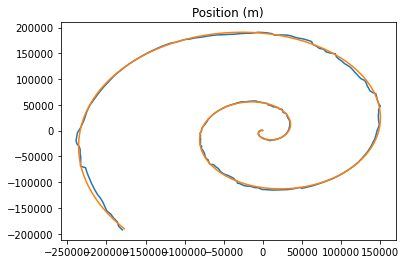

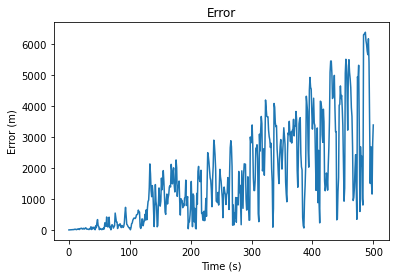

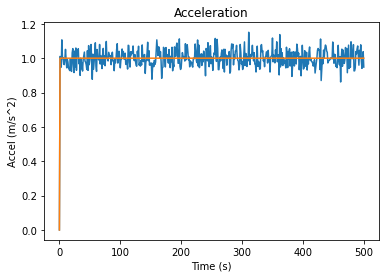

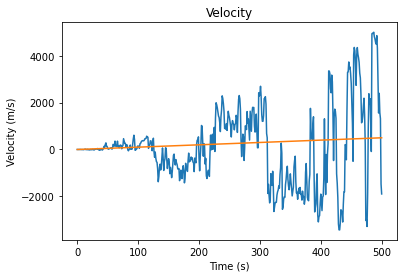

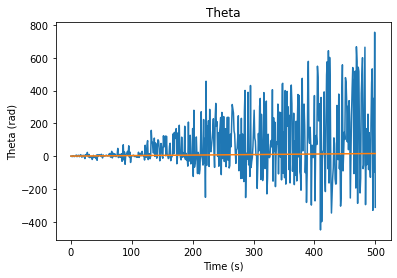

In [20]:
simulation = np.array(simulation, dtype=np.float32) # x, y, theta, v, b, a, P1, P2, P3, P4
actual_simulation = np.array(actual_simulation, dtype=np.float32)

error = np.sqrt((simulation[:,0] - actual_simulation[:,0])**2 + (simulation[:,1] - actual_simulation[:,1])**2)

Tf = np.linspace(0, T, T+1)

# plt.figure(11)
# plt.plot(Tf, simulation[:,0])
# plt.plot(Tf, actual_simulation[:,0])
# plt.xlabel("Time (s)")
# plt.ylabel("X Position (m)")
# plt.title("X Position")

# plt.figure(10)
# plt.plot(Tf, simulation[:,1])
# plt.plot(Tf, actual_simulation[:,1])
# plt.xlabel("Time (s)")
# plt.ylabel("Y Position (m)")
# plt.title("Y Position")

plt.figure(1)
plt.plot(simulation[:,0], simulation[:,1])
plt.plot(actual_simulation[:,0], actual_simulation[:,1])
plt.title("Position (m)")

plt.figure(2)
plt.plot(Tf, error)
plt.xlabel("Time (s)")
plt.ylabel("Error (m)")
plt.title("Error")

plt.figure(3)
plt.plot(Tf, simulation[:,5])
plt.plot(Tf, actual_simulation[:,5])
plt.xlabel("Time (s)")
plt.ylabel("Accel (m/s^2)")
plt.title("Acceleration")

plt.figure(4)
plt.plot(Tf, simulation[:,3])
plt.plot(Tf, actual_simulation[:,3])
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.title("Velocity")

plt.figure(12)
plt.plot(Tf, simulation[:,2])
plt.plot(Tf, actual_simulation[:,2])
plt.xlabel("Time (s)")
plt.ylabel("Theta (rad)")
plt.title("Theta")

Text(0.5, 1.0, 'Velocity Covariance')

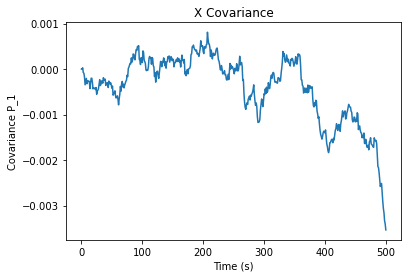

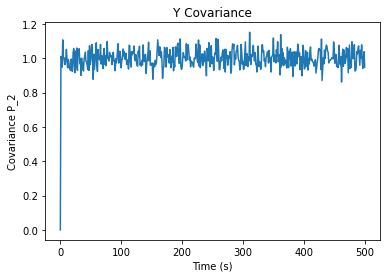

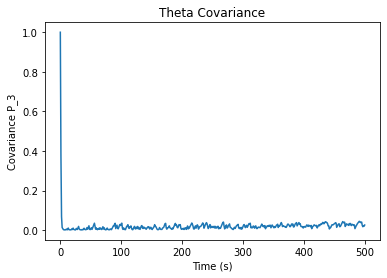

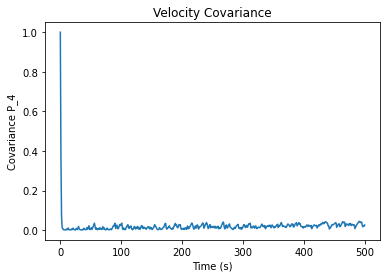

In [21]:
plt.figure(6)
plt.plot(Tf, simulation[:,4])
plt.xlabel("Time (s)")
plt.ylabel("Covariance P_1")
plt.title("X Covariance")

plt.figure(7)
plt.plot(Tf, simulation[:,5])
plt.xlabel("Time (s)")
plt.ylabel("Covariance P_2")
plt.title("Y Covariance")

plt.figure(8)
plt.plot(Tf, simulation[:,6])
plt.xlabel("Time (s)")
plt.ylabel("Covariance P_3")
plt.title("Theta Covariance")

plt.figure(9)
plt.plot(Tf, simulation[:,7])
plt.xlabel("Time (s)")
plt.ylabel("Covariance P_4")
plt.title("Velocity Covariance")
